### CONFIGURATION

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Hartwig imports
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import analyseVCF as aVCF
import venn as vn

In [3]:
import os
VCF_PATH = "/Users/peterpriestley/hmf/analyses/cancerSample/"
# SPECIFY SAMPLES
#VCF_SAMPLES = ["CPCT02010269"]
# OR Find all VCF FILES in VCF directory
VCF_SAMPLES=[]
for x in os.listdir(VCF_PATH):
    if x[-3:] == "vcf":
        VCF_SAMPLES.append(x[:12])
print VCF_SAMPLES

['CPCT02010267', 'CPCT02010269', 'CPCT02010272', 'CPCT02010299', 'CPCT02010306', 'CPCT02010307', 'CPCT02010313', 'CPCT02010326', 'CPCT02010327', 'CPCT02020217', 'CPCT02020234', 'CPCT02020257', 'CPCT02020272']


<h3> LOAD VCF

In [4]:
#Load all VCF_SAMPLES to DF
df = pd.DataFrame({})
for VCF_SAMPLE in VCF_SAMPLES:
    VCF_FILE_NAME = VCF_SAMPLE + "R_"+ VCF_SAMPLE + "T_merged_somatics.vcf"
    SAMPLE_NAMES = {VCF_SAMPLE + 'T.mutect':'mutect', \
                    VCF_SAMPLE + 'T.freebayes':'freebayes', \
                   'TUMOR.strelka':'strelka', \
                   'TUMOR.varscan':'varscan'}
    df = pd.concat([df,aVCF.loadVaraintsFromVCF(VCF_PATH,VCF_FILE_NAME,SAMPLE_NAMES,VCF_SAMPLE,True)])

reading vcf file: CPCT02010267R_CPCT02010267T_merged_somatics.vcf
Number variants loaded: 44651
reading vcf file: CPCT02010269R_CPCT02010269T_merged_somatics.vcf
reading VCF File line: 100000
Number variants loaded: 105189
reading vcf file: CPCT02010272R_CPCT02010272T_merged_somatics.vcf
reading VCF File line: 100000
Number variants loaded: 130305
reading vcf file: CPCT02010299R_CPCT02010299T_merged_somatics.vcf
Number variants loaded: 83224
reading vcf file: CPCT02010306R_CPCT02010306T_merged_somatics.vcf
Number variants loaded: 69901
reading vcf file: CPCT02010307R_CPCT02010307T_merged_somatics.vcf
Number variants loaded: 54815
reading vcf file: CPCT02010313R_CPCT02010313T_merged_somatics.vcf
Number variants loaded: 38797
reading vcf file: CPCT02010326R_CPCT02010326T_merged_somatics.vcf
Number variants loaded: 66724
reading vcf file: CPCT02010327R_CPCT02010327T_merged_somatics.vcf
Number variants loaded: 65940
reading vcf file: CPCT02020217R_CPCT02020217T_merged_somatics.vcf
Number v

<h3> CHECKS

In [1]:
#df[(df.variantType == "INDEL") & (df.variantSubType != "INSERT") & (df.variantSubType != "DELETE")]

<h3> High Level Stats

In [5]:
#minChromFrac = 17.443476
#maxChromFrac = 17.491846
#temp = df[(df.chromFrac > minChromFrac)&(df.chromFrac < maxChromFrac)]
pd.pivot_table(df, values='pos', index=['patientName'], columns=['variantType','numCallers'], aggfunc='count')

variantType    INDEL                Missing Genotype      SNP                           
numCallers         1       2      3                0        1        2        3        4
patientName                                                                             
CPCT02010267  2327.0    56.0    4.0              NaN  38262.0   3258.0    693.0     51.0
CPCT02010269  4310.0   461.0  185.0              NaN  53167.0  15510.0  23582.0   7974.0
CPCT02010272  8008.0  1733.0  513.0              1.0  60900.0   9492.0  35984.0  13674.0
CPCT02010299  7684.0   184.0   84.0              NaN  68423.0   2438.0   2452.0   1959.0
CPCT02010306  5891.0   707.0  252.0              1.0  42327.0   4680.0  11322.0   4721.0
CPCT02010307  3711.0    88.0    3.0              NaN  41549.0   6509.0   2869.0     86.0
CPCT02010313  4162.0    83.0   14.0              NaN  31876.0   1930.0    472.0    260.0
CPCT02010326  4851.0   401.0   94.0              1.0  41592.0   5972.0  11767.0   2046.0
CPCT02010327  3699.0    52.0    6.0              2.0  53728.0   7190.0   1176.0     87.0
CPCT02020217  3816.0   317.0  185.0              NaN  36528.0   3629.0   3119.0   2560.0
CPCT02020234  3976.0   377.0  176.0              2.0  52836.0   5129.0  21991.0  17540.0
CPCT02020257  3299.0   131.0   51.0              NaN  33643.0   1883.0   1243.0    979.0
CPCT02020272  6495.0   363.0  199.0              3.0  97446.0  33558.0   3709.0   2780.0

In [22]:

df[['pos','chrom','patientName']].groupby(['pos','chrom']).agg('count').sort_values(['patientName'], ascending=False).head(100)


,,patientName
pos,chrom,
204592169,2,9
10841105,21,8
22633913,22,8
102619226,2,8
43966329,14,8
43096647,8,7
62210916,6,7
10021380,Y,7
128967861,12,7


In [7]:
#INTERNAL 'PRECISION' + 'SENSITIVITY' per caller
outputdata = []
variantTypes = df.variantType.unique()`a
patientNames = df.patientName.unique()
for patientName in patientNames:
    for variantType in variantTypes:
        truthSet = len(df[(df['numCallers'] >= 2)&(df['variantType'] == variantType)&(df['patientName'] == patientName)])
        for columnName in list(df):
            if columnName.endswith('allele'):
                myCaller = columnName[:-6]
                truePositives = len(df[(df[myCaller+'allele'] != '')&(df['numCallers'] >=2) &\
                                   (df['variantType'] == variantType)&(df['patientName'] == patientName)])
                falseNegatives = len(df[(df[myCaller+'allele'] == '')&(df['numCallers'] >= 2) &\
                                    (df['variantType'] == variantType)&(df['patientName'] == patientName)])
                positives = len(df[(df[myCaller+'allele'] != '')&\
                                   (df['variantType'] == variantType)&(df['patientName'] == patientName)]) 
                if positives > 0:
                    outputdata.append([patientName,variantType, myCaller, truthSet,truePositives,\
                                   positives-truePositives, falseNegatives, \
                                   round(truePositives/float(positives),4),round(truePositives/float(truthSet),4)])
   
outputDF = pd.DataFrame(outputdata)
outputDF.columns = (['patientName','variantType','caller','truthSet','truePositives','falsePositives','falseNegatives',\
                     'internalPrecision','internalSensitivity'])
outputDF.sort_values(['patientName','variantType','caller']).head(8)

,patientName,variantType,caller,truthSet,truePositives,falsePositives,falseNegatives,internalPrecision,internalSensitivity
6,CPCT02010267,INDEL,freebayes,60,55,1096,5,0.0478,0.9167
4,CPCT02010267,INDEL,strelka,60,9,14,51,0.3913,0.1500
5,CPCT02010267,INDEL,varscan,60,60,1217,0,0.0470,1.0000
3,CPCT02010267,SNP,freebayes,4002,684,12680,3318,0.0512,0.1709
2,CPCT02010267,SNP,mutect,4002,2903,17841,1099,0.1399,0.7254
0,CPCT02010267,SNP,strelka,4002,3361,4914,641,0.4062,0.8398
1,CPCT02010267,SNP,varscan,4002,1851,2827,2151,0.3957,0.4625
13,CPCT02010269,INDEL,freebayes,646,356,1694,290,0.1737,0.5511


In [ ]:
df[['variantType','pos']].groupby(['variantType']).agg('count')

<h3> SNP Venn

In [8]:
snpdf = df[(df.variantType == 'SNP')]

In [9]:
snpdf[['numCallers','patientName','pos']].groupby(['patientName','numCallers']).agg('count')

pos
patientName  numCallers       
CPCT02010267 1           38262
             2            3258
             3             693
             4              51
CPCT02010269 1           53167
             2           15510
             3           23582
             4            7974
CPCT02010272 1           60900
             2            9492
             3           35984
             4           13674
CPCT02010299 1           68423
             2            2438
             3            2452
             4            1959
CPCT02010306 1           42327
             2            4680
             3           11322
             4            4721
CPCT02010307 1           41549
             2            6509
             3            2869
             4              86
CPCT02010313 1           31876
             2            1930
             3             472
             4             260
CPCT02010326 1           41592
             2            5972
             3           11767
             4            2046
CPCT02010327 1           53728
             2            7190
             3            1176
             4              87
CPCT02020217 1           36528
             2            3629
             3            3119
             4            2560
CPCT02020234 1           52836
             2            5129
             3           21991
             4           17540
CPCT02020257 1           33643
             2            1883
             3            1243
             4             979

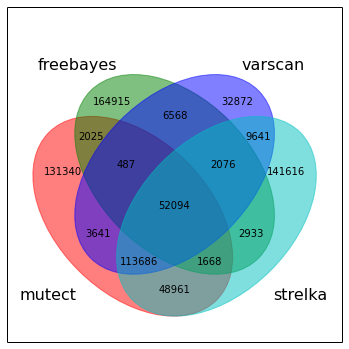

In [10]:
vn.venn([snpdf[snpdf.mutectallele != '']['chromPos'], \
         snpdf[snpdf.strelkaallele != '']['chromPos'], \
        snpdf[snpdf.freebayesallele != '']['chromPos'], \
        snpdf[snpdf.varscanallele != '']['chromPos'] \
        ],['mutect','strelka','freebayes','varscan'],figsize=(6,6))

### <hd1> Indel Venn

In [11]:
indeldf= df[(df.variantType == 'INDEL')]

In [12]:
indeldf[['numCallers','vennSegment','pos']].groupby(['numCallers','vennSegment']).agg('count')

,,pos
numCallers,vennSegment,
1,,55734
2,,4590
3,,1567


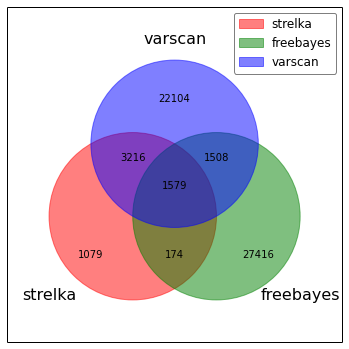

In [13]:
vn.venn([indeldf[indeldf.strelkaallele != '']['chromPos'], \
        indeldf[indeldf.freebayesallele != '']['chromPos'], \
        indeldf[indeldf.varscanallele != '']['chromPos'] \
        ],['strelka','freebayes','varscan'],figsize=(6,6))

<h3> Allelic Depth

In [15]:
#Alllele Freq By Caller
for columnName in list(snpdf):
    if columnName.endswith('allele'):
        ser = snpdf[snpdf[columnName] != ''][columnName[:-6] + 'AF']
        ser = ser.sort_values()
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
        ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by Caller",figsize=[15,6])

KeyError: 'strelkaAF'

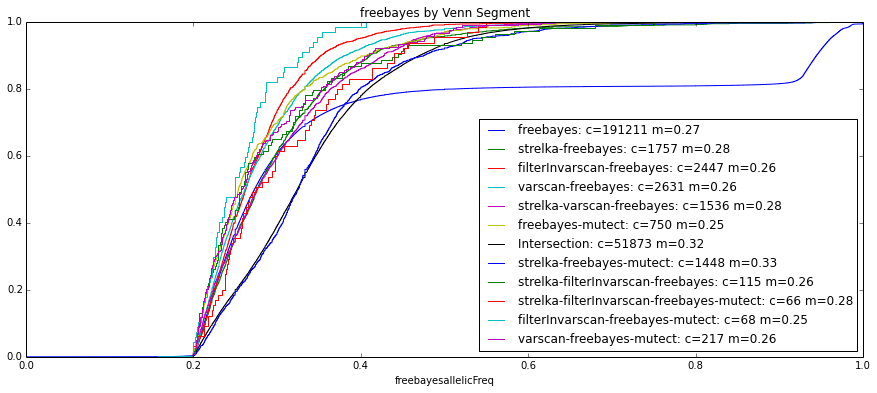

In [15]:
# BY CALLER BY VENN SEGMENT - Single Caller
myCaller = 'freebayes'
vennSegments = snpdf[snpdf[myCaller+'allele'] != ''].vennSegment.unique()
for vennSegment in vennSegments:
    ser = snpdf[(snpdf.vennSegment == vennSegment) & (snpdf[myCaller+'allele'] != '')][myCaller+'allelicFreq']
    ser = ser.sort_values()
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=vennSegment+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=myCaller+" by Venn Segment",figsize=[15,6])

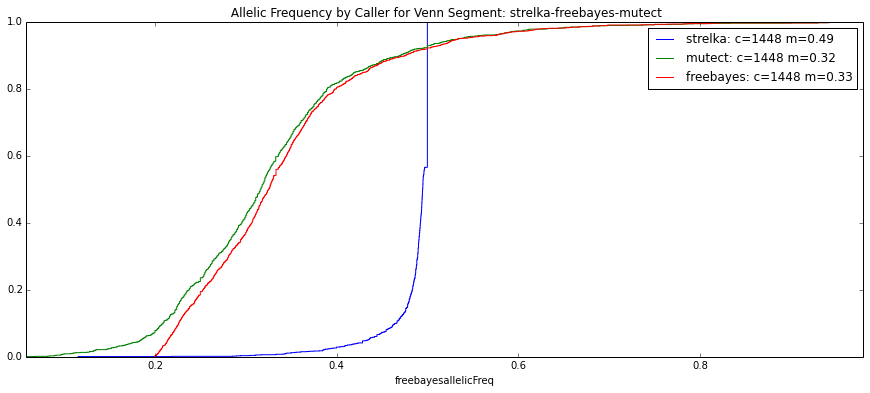

In [16]:
# BY CALLER BY VENN SEGMENT - Single Venn Segment
myVennSegment = 'strelka-freebayes-mutect'
for columnName in list(snpdf):
    if columnName.endswith('allele') and ((columnName[:-6] in myVennSegment) or (myVennSegment == 'Intersection')):
        ser = snpdf[(snpdf[columnName] != '') & (snpdf.vennSegment == myVennSegment)][columnName[:-6] + 'allelicFreq']
        ser = ser.sort_values()
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
        ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by Caller for Venn Segment: " \
                     +myVennSegment,figsize=[15,6])

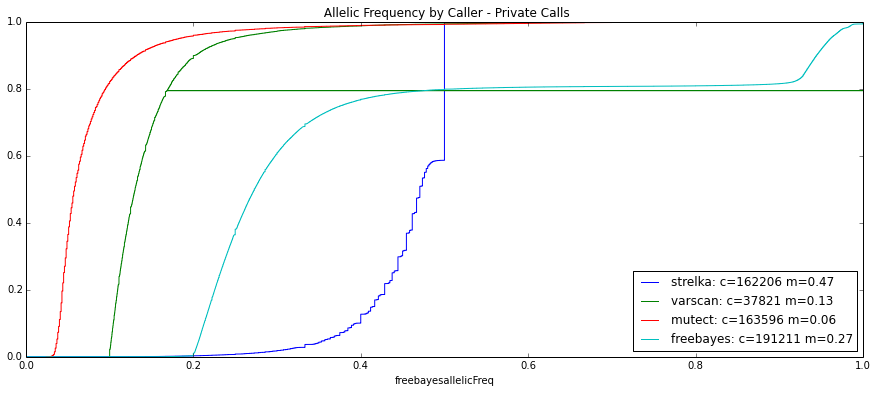

In [17]:
#Alllele Freq By Caller PRIVATE
for columnName in list(snpdf):
    if columnName.endswith('allele'):
        ser = snpdf[(snpdf[columnName] != '') & (snpdf.numCallers == 1)][columnName[:-6] + 'allelicFreq']
        ser = ser.sort_values()
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
        ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by Caller - Private Calls",figsize=[15,6])

### Allelic Depth Scatter Plot

In [ ]:
caller1 = 'varscan'
caller2 = 'strelka'
tempdf = df[(df[caller1+'allele']!='')&(df[caller2+'allele']!='')]
tempdf.head()
tempdf.plot.scatter(caller1+'allelicFreq',caller2+'allelicFreq' \
                        ,figsize=[6,6] \
                        ,title="Comparison of "+caller1+" and "+caller2+" Allelic Frequency" \
                        ,xlim=[0,1],ylim=[0,1])

<h3> RAINBOW CHARTS

In [ ]:
## RAINBOW
#plt.scatter(df[df.caller == 'mutect'].chromFrac, df[df.caller == 'mutect'].allelicFreq, s=10, c='b', marker="s")